# Analysis of the AMLTK Pipeline
OpenFE-like Analysis

### To Do for the User

In [5]:
# No more To Dos

### Imports


In [6]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Files

In [7]:
files = os.listdir(os.curdir)
parquet_files = []
for file in files:
    if file.endswith(".parquet") and not file.__contains__("tabular_data"):
        parquet_files.append(file)
print(parquet_files)

['results_abalone_dataset_autogluon_0.parquet', 'results_moneyball_dataset_autofeat_0.parquet', 'results_moneyball_dataset_autogluon_0.parquet', 'results_moneyball_dataset_original_0.parquet', 'results_bioresponse_dataset_h2o_0.parquet', 'results_australian_dataset_correlationBasedFS_0.parquet', 'results_abalone_dataset_original_0.parquet', 'results_bioresponse_dataset_mljar_0.parquet', 'results_australian_dataset_boruta_0.parquet', 'results_abalone_dataset_autofeat_0.parquet', 'results_australian_dataset_h2o_0.parquet']


In [8]:
df_all = pd.DataFrame(columns=['Dataset', 'Method', 'Fold', 'Value'])

for file in parquet_files:
    print(file)
    core_name = file[len('results_'):-len('.parquet')]
    parts = core_name.split('_')
    dataset = parts[0]
    method = parts[2]
    fold = parts[3]
    
    df = pd.read_parquet(file)
    df = df[df['status'] == 'success']
    metric_accuracy = df["metric:roc_auc_ovo [0.0, 1.0] (maximize)"].tolist()
    value = np.average(metric_accuracy)
    df_all = df_all._append({'Dataset': dataset, 'Method': method, 'Fold': fold, 'Value': value}, ignore_index=True)
print(df_all)

results_abalone_dataset_autogluon_0.parquet
results_moneyball_dataset_autofeat_0.parquet
results_moneyball_dataset_autogluon_0.parquet
results_moneyball_dataset_original_0.parquet
results_bioresponse_dataset_h2o_0.parquet
results_australian_dataset_correlationBasedFS_0.parquet
results_abalone_dataset_original_0.parquet
results_bioresponse_dataset_mljar_0.parquet
results_australian_dataset_boruta_0.parquet
results_abalone_dataset_autofeat_0.parquet
results_australian_dataset_h2o_0.parquet
        Dataset              Method Fold     Value
0       abalone           autogluon    0  0.893359
1     moneyball            autofeat    0  0.872661
2     moneyball           autogluon    0  0.848152
3     moneyball            original    0  0.849608
4   bioresponse                 h2o    0  0.860691
5    australian  correlationBasedFS    0  0.880407
6       abalone            original    0  0.896770
7   bioresponse               mljar    0  0.871477
8    australian              boruta    0  0.8795

In [9]:
# Standard Deviation
df_stddev = df_all.groupby(['Dataset', 'Method'])['Value'].std().reset_index()
df_stddev.rename(columns={'Value': 'StdDev'}, inplace=True)
df_stddev['StdDev'] = df_stddev['StdDev'].fillna(0)
# Average values
df_summary = df_all.groupby(['Dataset', 'Method'])['Value'].mean().reset_index().fillna(0)

In [10]:
# Add standard deviation to the averages values
df_summary = pd.merge(df_summary, df_stddev)
df_summary['Value_with_StdDev'] = df_summary.apply(lambda row: f"{row['Value']} ± {row['StdDev']}", axis=1)

In [11]:
# Print and write to file
pivot_table = df_summary.pivot(index='Dataset', columns='Method', values='Value_with_StdDev').fillna('0 ± 0')
pivot_table.reset_index(inplace=True)
pivot_table.to_parquet('tabular_data.parquet')
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+---+-------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+
|   |   Dataset   |         autofeat         |        autogluon         |          boruta          |    correlationBasedFS    |           h2o            |          mljar           |         original         |
+---+-------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+
| 0 |   abalone   | 0.8791619555562445 ± 0.0 | 0.8933593902001659 ± 0.0 |          0 ± 0           |          0 ± 0           |          0 ± 0           |          0 ± 0           | 0.8967698071278396 ± 0.0 |
| 1 | australian  |          0 ± 0           |          0 ± 0           | 0.8795748590552972 ± 0.0 | 0.8804072722834173 ± 0.0 |   0.910574796605 ± 0.0   |          

### Boxplots

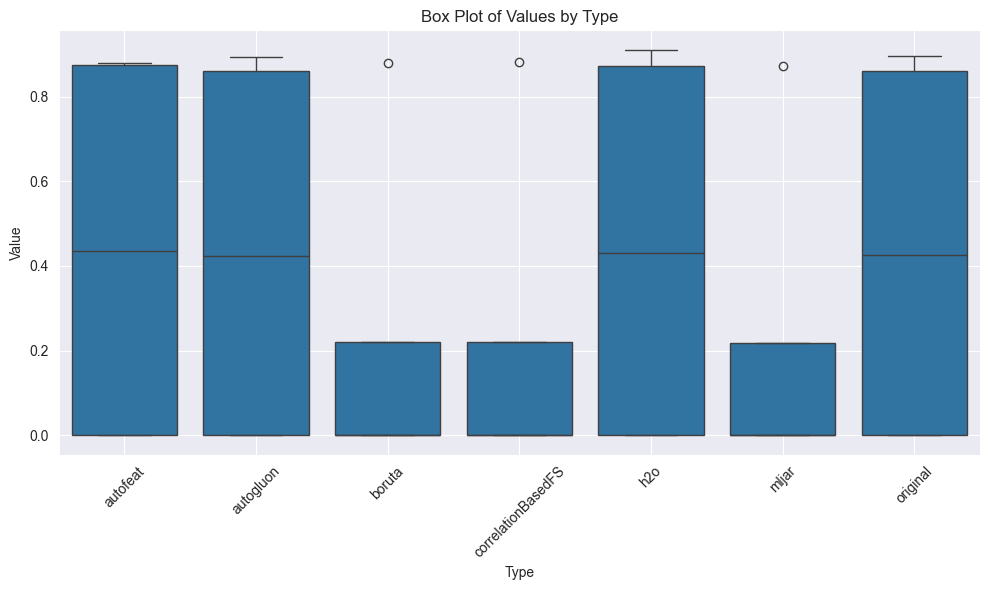

In [12]:
# Extract values
def extract_value(value_with_stddev):
    value, _ = value_with_stddev.split(' ± ')
    return float(value)

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

# Melt DataFrame to format for seaborn
melted_df = pd.melt(pivot_table_numeric, id_vars=['Dataset'], var_name='Type', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Value', data=melted_df)
plt.xlabel("Type")
plt.ylabel("Value")
plt.title("Box Plot of Values by Type")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/box_plot.png')
plt.show()